# Convnet based Model

## Import packages

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json

from keras.models import Sequential,Model
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda
from keras.layers import Conv1D , Flatten, Input
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D



from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping
from keras import backend as K



from IPython.lib.display import FileLink





from sklearn.model_selection import train_test_split


Using TensorFlow backend.


## Initialize global variables

In [2]:


path = '/home/ubuntu/quora/'
data_home = path +"data/"

Q1_TRAINING_DATA_FILE = data_home+'cache/q1_train.npy'
Q2_TRAINING_DATA_FILE = data_home+'cache/q2_train.npy'
LABEL_TRAINING_DATA_FILE = data_home+'cache/label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = data_home+'cache/word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = data_home+'cache/nb_words.json'
Q1_TESTING_DATA_FILE = data_home+'q1_test.npy'
Q2_TESTING_DATA_FILE = data_home+'q2_test.npy'


MAX_SEQUENCE_LENGTH = 35
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25


re_weight = True # whether to re-weight classes to fit the 17.5% share in test set


## Load the dataset, embedding matrix and word count

In [3]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

In [4]:
q1_data.shape,q2_data.shape

((404290, 35), (404290, 35))

##### Read hand-made features by abhishek 

In [5]:
abhishek_train = pd.read_csv(data_home+"abhishek_train_features.csv")
abhishek_test = pd.read_csv(data_home+"abhishek_test_features.csv")

In [36]:
abhishek_train.columns

Index([u'question1', u'question2', u'len_q1', u'len_q2', u'diff_len',
       u'len_char_q1', u'len_char_q2', u'len_word_q1', u'len_word_q2',
       u'common_words', u'fuzz_qratio', u'fuzz_WRatio', u'fuzz_partial_ratio',
       u'fuzz_partial_token_set_ratio', u'fuzz_partial_token_sort_ratio',
       u'fuzz_token_set_ratio', u'fuzz_token_sort_ratio', u'wmd', u'norm_wmd',
       u'cosine_distance', u'cityblock_distance', u'jaccard_distance',
       u'canberra_distance', u'euclidean_distance', u'minkowski_distance',
       u'braycurtis_distance', u'skew_q1vec', u'skew_q2vec', u'kur_q1vec',
       u'kur_q2vec'],
      dtype='object')

In [37]:
abhishek_train.head(1)

,question1,question2,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,66,57,9,20,20,14,12,10,...,5.081614,1.0,94.023324,0.371408,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301


In [38]:
len(abhishek_train),len(abhishek_test)

(404290, 2345796)

In [39]:
q1_features = [u'len_q1', u'len_char_q1', u'len_word_q1', u'skew_q1vec', u'kur_q1vec']
q2_features = [u'len_q2', u'len_char_q2', u'len_word_q2', u'skew_q2vec', u'kur_q2vec']
diff_features = abhishek_train.columns.difference(q1_features).difference(q2_features).difference(['question1','question2'])

In [40]:
from sklearn.preprocessing import normalize

def get_and_normalize_features(df, feature_list):
    
    np_version = np.array(df.ix[:,feature_list])
    np_version = np.nan_to_num(np_version)
    np_version = normalize(np_version ,axis=0,norm='max')
    
    return np_version

In [41]:
# abhishek_np= np.array(abhishek_train.ix[:,2:])
# abhishek_np = np.nan_to_num(abhishek_np)
# abhishek_np[abhishek_np==0]=1e-5

# abhishek_np / abhishek_np.sum(axis=1)[:,np.newaxis]
# abhishek_np = normalize(abhishek_np ,axis=0,norm='max')

In [42]:
q1_features_np = get_and_normalize_features(abhishek_train,q1_features)
q2_features_np = get_and_normalize_features(abhishek_train,q2_features)
diff_features_np = get_and_normalize_features(abhishek_train,diff_features)

In [43]:
q1_features_np.shape,q2_features_np.shape,diff_features_np.shape

((404290, 5), (404290, 5), (404290, 18))

#### Read question frequency features

In [44]:
q_frequency = pd.read_csv("data/question_frequency_train.csv")


In [45]:
q1_features_np.shape,np.reshape(q_frequency.q1_freq,-1,1).shape

((404290, 5), (404290,))

In [46]:
q1_features_np = np.append(q1_features_np,q_frequency.q1_freq[:,None],1)

In [47]:
q2_features_np = np.append(q2_features_np,q_frequency.q2_freq[:,None],1)

#### Read "group frequency" features (NOT GOOD - IGNORE)

In [48]:
# group_freq_train = pd.read_csv("data/training_with_group_freq.csv")



In [49]:
# q1_features_np = np.append(q1_features_np,group_freq_train.q1_group_frequency[:,None],1)

In [50]:
# q2_features_np = np.append(q2_features_np,group_freq_train.q2_group_frequency[:,None],1)

#### Read "same group" feature (DATA LEAK - IGNORE)

In [51]:
# same_group_train = pd.read_csv("data/same_group_train.csv",)
# diff_features_np = np.append(diff_features_np,same_group_train.same_group[:,None],1)


#### Read Nostrov's features 


In [6]:
nostrov = pd.read_csv('data/nestrov_feats.csv')

In [7]:
ix_train = np.where(nostrov['id'] >= 0)[0]
ix_test = np.where(nostrov['id'] == -1)[0]
# ix_is_dup = np.where(nostrov['is_duplicate'] == 1)[0]
# ix_not_dup = np.where(nostrov['is_duplicate'] == 0)[0]

In [9]:
nostrov_diff = nostrov.ix[:,9:]

In [10]:
nostrov_diff.columns

Index([u'abs_diff_len1_len2', u'log_abs_diff_len1_len2', u'ratio_len1_len2',
       u'log_ratio_len1_len2', u'unigram_jaccard', u'unigram_all_jaccard',
       u'unigram_all_jaccard_max', u'bigram_jaccard', u'bigram_all_jaccard',
       u'bigram_all_jaccard_max', u'trigram_jaccard', u'trigram_all_jaccard',
       u'trigram_all_jaccard_max', u'quadgram_jaccard',
       u'quadgram_all_jaccard', u'quadgram_all_jaccard_max',
       u'quadram_tfidf_cosine', u'quadgram_tfidf_l2_euclidean',
       u'quadgram_tfidf_l1_euclidean', u'quadgram_tf_l2_euclidean',
       u'm_q1_q2_tf_oof', u'm_vstack_svd_q1_q1_euclidean',
       u'm_vstack_svd_q1_q1_cosine', u'm_vstack_svd_mult_q1_q2_oof',
       u'm_vstack_svd_absdiff_q1_q2_oof', u'1wl_tfidf_cosine',
       u'1wl_tfidf_l2_euclidean', u'1wl_tf_l2_euclidean', u'm_w1l_tfidf_oof'],
      dtype='object')

In [26]:
nostrov_diff.iloc[ix_train].shape

(404290, 29)

In [52]:
diff_features_np = np.hstack((diff_features_np,nostrov_diff.iloc[ix_train].values))

In [53]:
diff_features_np.shape

(404290, 47)

## Partition the dataset into train and test sets

In [27]:
# perm = np.random.permutation(len(abhishek_train))

In [28]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
# Q1_train = X_train[:,0]
# Q2_train = X_train[:,1]
# Q1_test = X_test[:,0]
# Q2_test = X_test[:,1]

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=2019)


for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    abhishek_train_train, abhishek_train_valid = abhishek_np[train_index], abhishek_np[test_index]

Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]




In [14]:
len(Q1_train),len(Q2_train),len(y_train),len(Q1_test),len(Q1_test),len(y_test)

(363861, 363861, 363861, 40429, 40429, 40429)

### Make random shuffle dataset



In [54]:
np.random.seed(2189)

perm = np.random.permutation(len(q1_data))
idx_train = perm[:int(len(q1_data)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(q1_data)*(1-VALIDATION_SPLIT)):]

In [55]:
idx_train

array([298787, 215457, 331096, ...,  74226,  16804, 131445])

In [56]:
q1_features_np.shape,q2_features_np[idx_train].shape,diff_features_np[idx_train].shape

((404290, 6), (363861, 6), (363861, 47))

In [57]:
## training data

## normal word2vec embeddings
Q1_train = np.vstack((q1_data[idx_train], q2_data[idx_train]))
Q2_train = np.vstack((q2_data[idx_train], q1_data[idx_train]))


## hand-crafted features
train_features_part1 = np.hstack( (q1_features_np[idx_train] ,q2_features_np[idx_train], diff_features_np[idx_train]))
train_features_part2 = np.hstack( (q2_features_np[idx_train] ,q1_features_np[idx_train], diff_features_np[idx_train]))

abhishek_train_train = np.concatenate((train_features_part1, train_features_part2))

y_train = np.concatenate((labels[idx_train], labels[idx_train]))


## validation data
Q1_test = np.vstack((q1_data[idx_val], q2_data[idx_val]))
Q2_test = np.vstack((q2_data[idx_val], q1_data[idx_val]))

valid_features_part1 = np.hstack( (q1_features_np[idx_val] ,q2_features_np[idx_val], diff_features_np[idx_val]))
valid_features_part2 = np.hstack( (q2_features_np[idx_val] ,q1_features_np[idx_val], diff_features_np[idx_val]))

abhishek_train_valid = np.concatenate((valid_features_part1, valid_features_part2))


y_test = np.concatenate((labels[idx_val], labels[idx_val]))




In [58]:
# len(Q1_train),len(Q2_train),len(y_train),len(Q1_test),len(Q1_test),len(y_test)

In [59]:
abhishek_train_train.shape

(727722, 59)

## Define the model

### Set weights 

In [60]:
re_weight = True 

if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None
    
    
weight_val = np.ones(len(y_test))
if re_weight:
    weight_val *= 0.472001959
    weight_val[y_test==0] = 1.309028344    

In [61]:
def get_convs():
#v2
    graph_in = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedded = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(graph_in)
    
#     normalized_input = BatchNormalization()(embedded)
    
    convs = []

    for fsz in range(2,6):
        conv = Conv1D(64, fsz,
                      padding = 'valid', activation='relu')(embedded)#
        conv = Dropout(0.3)(conv)
        conv = BatchNormalization()(conv)        
        
        pool = MaxPooling1D(pool_size=2)(conv)
        flatten = Flatten()(pool)
#         pool = GlobalMaxPooling1D()(conv)
        convs.append(flatten)

    out = concatenate(convs) 
    graph = Model(inputs=graph_in,outputs=out)

    return graph


# v1
#     graph_in = Input(shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM))
#     convs = []

#     for fsz in range(3,6):
#         conv = Conv1D(256, fsz,strides=1,
#                             padding = 'valid', activation='relu')(graph_in)#

#         pool = MaxPooling1D(pool_length=2)(conv)
#         flatten = Flatten()(pool)
#         convs.append(flatten)

#     out = Merge(mode='concat')(convs) 
#     graph = Model(input=graph_in,output=out)


In [70]:

from keras.layers import Dense, Dropout, Lambda, merge, BatchNormalization, Activation, Input, Merge

def create_input_resnet():
    
    ## raw word2vecs gone through resnet
    input_vec = Input(shape=(MAX_SEQUENCE_LENGTH, ))
    
    
    dense1 = Dense(128)(input_vec)
    bn1 = BatchNormalization()(dense1)
    relu1 = Activation('relu')(bn1)

    dense2 = Dense(128)(relu1)
    bn2 = BatchNormalization()(dense2)
    res2 = merge([relu1, bn2], mode='sum')
    relu2 = Activation('relu')(res2)    

    dense3 = Dense(128)(relu2)
    bn3 = BatchNormalization()(dense3)
    res3 = Merge(mode='sum')([relu2, bn3])
    relu3 = Activation('relu')(res3)   

    feats = merge([relu3, relu2, relu1], mode='concat')
    bn4 = BatchNormalization()(feats)
    
    
    graph = Model(inputs=input_vec,outputs=bn4)

    
    return graph


In [71]:
from keras.layers import concatenate

### add computation graph to question 1 embeddings
graph = get_convs()

q1_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
q2_input = Input(shape=(MAX_SEQUENCE_LENGTH,))

Q1 = graph(q1_input)
Q2 = graph(q2_input)


q1q2 = concatenate([Q1, Q2])


# q1q2 = BatchNormalization()(q1q2)
# q1q2 = Dense(200, activation='relu')(q1q2)
# q1q2 = Dropout(0.2)(q1q2)

# model.add(BatchNormalization())
# model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.2))



## Add Abhishek features

abhishek_features = Input((59,),name="abhishek_features")
# abhishek_features_normalized = BatchNormalization()(abhishek_features)

# input resnets
resnet = create_input_resnet()
Q1_res = resnet(q1_input)
Q2_res = resnet(q2_input)




model = concatenate([Q1,Q2,Q1_res,Q2_res,abhishek_features])
model =Dropout(0.2)(model)

model = BatchNormalization()(model)
model =Dense(200, activation='relu')(model)

model =Dropout(0.2)(model)
model =BatchNormalization()(model)
model =Dense(200, activation='relu')(model)


model =Dropout(0.2)(model)
model =BatchNormalization()(model)
model =Dense(1, activation='sigmoid')(model)

model = Model(inputs=[q1_input,q2_input,abhishek_features],outputs=model)

model.compile(loss='binary_crossentropy', 
              optimizer='nadam', 
              metrics=['accuracy'])#, 'precision', 'recall', 'fbeta_score'])

/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


## Train the model, checkpointing weights with best validation accuracy

In [72]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()

MODEL_WEIGHTS_FILE = path+'weights/1d_conv_v2_abhishek_qfreq_nostrov2_res_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.h5'

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_loss', save_best_only=True),early_stopping]

history = model.fit([Q1_train, Q2_train,abhishek_train_train],
                    y_train,
                    epochs=50,
                    batch_size=1024,
#                     validation_split=0.2,
                    validation_data = ([Q1_test, Q2_test,abhishek_train_valid],y_test,weight_val),
                    callbacks=callbacks,
                    shuffle=True,
                    class_weight=class_weight)


t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-05-11 19:49:39.214206
Train on 727722 samples, validate on 80858 samples
Epoch 1/50
727722/727722 [==============================] - 156s - loss: 0.3305 - acc: 0.7441 - val_loss: 0.2814 - val_acc: 0.7531
Epoch 2/50
727722/727722 [==============================] - 148s - loss: 0.2725 - acc: 0.7871 - val_loss: 0.2559 - val_acc: 0.7755
Epoch 3/50
727722/727722 [==============================] - 148s - loss: 0.2527 - acc: 0.8075 - val_loss: 0.2429 - val_acc: 0.8150
Epoch 4/50
727722/727722 [==============================] - 148s - loss: 0.2390 - acc: 0.8220 - val_loss: 0.2407 - val_acc: 0.8344
Epoch 5/50
727722/727722 [==============================] - 148s - loss: 0.2283 - acc: 0.8313 - val_loss: 0.2356 - val_acc: 0.8352ss: 0 - ETA: 0s - loss: 0.2283 - acc: 0
Epoch 6/50
727722/727722 [==============================] - 148s - loss: 0.2183 - acc: 0.8410 - val_loss: 0.2353 - val_acc: 0.8240
Epoch 7/50
727722/727722 [==============================] - 148s - loss: 0.2

## Plot training and validation accuracy

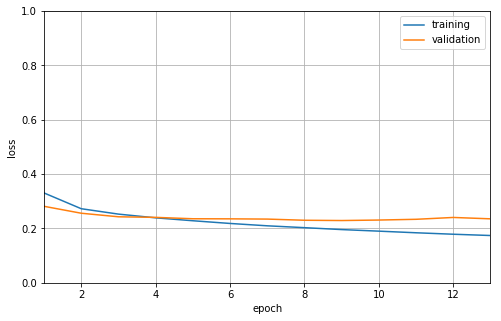

In [73]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("loss")
ax.set_ylim([0.0,1.0]);

## Print best validation accuracy and epoch

without cleaning: Maximum accuracy at epoch 8 = 0.8227
with cleaning: Maximum accuracy at epoch 15 = 0.8268
with cleaning and stratified: 0.8275

In [74]:
max_val_acc, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum Loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Minimum Loss at epoch 9 = 0.2291


# LOAD the best weights

In [39]:
# !ls weights/

In [75]:
model.load_weights(path+"weights/1d_conv_v2_abhishek_qfreq_nostrov2_res_epoch_08_val_loss_0.2291.h5")


## Evaluate the model with best validation accuracy on the test partition

In [42]:
# loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test) #, precision, recall, fbeta_score
# print('')
# print('loss      = {0:.4f}'.format(loss))
# print('accuracy  = {0:.4f}'.format(accuracy))
# # print('precision = {0:.4f}'.format(precision))
# print('recall    = {0:.4f}'.format(recall))
# print('F         = {0:.4f}'.format(fbeta_score))

In [51]:
val_preds = model.predict([Q1_test, Q2_test,abhishek_train_valid])

from sklearn.metrics import log_loss


print (log_loss(y_test,val_preds))
print (log_loss(y_test,np.clip(val_preds,1-0.90,0.90)))
print (log_loss(y_test,np.clip(val_preds,1-0.98,0.98)))
print (log_loss(y_test,np.clip(val_preds,1-0.99,0.99)))


0.390226398346
0.409532141018
0.390492689424
0.389423437025


## Making predictions on test set

#### load features

In [76]:
abhishek_test = pd.read_csv(data_home+"abhishek_test_features.csv")

In [77]:
q_frequency_test = pd.read_csv("data/question_frequency_test.csv")

In [18]:
# group_freq_test = pd.read_csv("data/test_with_group_freq.csv")
del group_freq_test

In [78]:
q1_test_data = np.load(open(data_home+"cache/"+Q1_TESTING_DATA_FILE, 'rb'))
q2_test_data = np.load(open(data_home+"cache/"+Q2_TESTING_DATA_FILE, 'rb'))

In [65]:
# del abhishek_np # to avoid messing

In [12]:
# same_group_test = pd.read_csv("data/same_group_test.csv",)


#### prepare features

In [79]:
q1_features_np = get_and_normalize_features(abhishek_test,q1_features)
q2_features_np = get_and_normalize_features(abhishek_test,q2_features)
diff_features_np = get_and_normalize_features(abhishek_test,diff_features)

In [80]:
diff_features_np = np.hstack((diff_features_np,nostrov_diff.iloc[ix_test].values))



In [81]:
q1_features_np = np.append(q1_features_np,q_frequency_test.q1_freq[:,None],1)
q2_features_np = np.append(q2_features_np,q_frequency_test.q2_freq[:,None],1)

In [68]:
#data leak, hurt log_loss ignore
# q1_features_np = np.append(q1_features_np,group_freq_test.q1_group_frequency[:,None],1)
# q2_features_np = np.append(q2_features_np,group_freq_test.q2_group_frequency[:,None],1)

In [72]:
# diff_features_np = np.append(diff_features_np,same_group_test.same_group[:,None],1)


In [82]:
test_features_part1 = np.hstack( (q1_features_np ,q2_features_np, diff_features_np))
test_features_part2 = np.hstack( (q2_features_np ,q1_features_np, diff_features_np))


In [83]:
%%time

preds = model.predict([q1_test_data,q2_test_data,test_features_part1], batch_size=8192)
preds_reverse = model.predict([q2_test_data,q1_test_data,test_features_part2], batch_size=8192)

CPU times: user 50.6 s, sys: 10.2 s, total: 1min
Wall time: 4min 51s


In [84]:
preds = (preds + preds_reverse)/2.0

In [85]:
preds.shape

(2345796, 1)

In [86]:

flattend = preds.flatten()
clipped = flattend

# clip =0.98
# clipped = np.clip(flattend,1-clip,clip)

In [87]:
df_test = pd.read_csv(data_home+'test.csv')

sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': clipped})
sub.head(2)

,is_duplicate,test_id
0,0.002620,0
1,0.221141,1


In [88]:
submission_name = "subm/conv1_v2_maxpool2_abhishek_qfreq_nostrov_res.csv"

sub.to_csv(path+submission_name, index=False)

In [89]:

FileLink(submission_name)

/home/ubuntu/quora/subm/conv1_v2_maxpool2_abhishek_qfreq_nostrov_res.csv

### setting is_duplicate to 1 for those questions that belong to the same group

hurt performance

In [21]:
# best_preds is from 1d convs + question frequency magic feature
best_preds.ix[(best_preds.same_group > 0) , "is_duplicate"] = 0.9999

In [22]:
# best_preds.ix[best_preds.same_group > 0].is_duplicate

In [23]:
best_preds[best_preds.same_group > 0].mean()

is_duplicate    9.999000e-01
test_id         1.061650e+06
same_group      1.000000e+00
dtype: float64

In [24]:
best_preds.drop("same_group", axis=1, inplace=True)

In [26]:
best_preds.to_csv("subm/qfreq_and_samegrouptomax_3.csv",index=False)

In [28]:
FileLink("subm/qfreq_and_samegrouptomax_3.csv")

/home/ubuntu/quora/subm/qfreq_and_samegrouptomax_3.csv

#### Exact same questions? 
setting 1 for these questions wouldn't make a difference in score at all; they seem to be all machine generated .. 

In [48]:
best_preds["same_question"] = same_group_test.question1 == same_group_test.question2

In [49]:
best_preds[best_preds["same_question"]>0].count()

is_duplicate     60
test_id          60
same_question    60
dtype: int64

In [50]:
best_preds[best_preds["same_question"]>0].mean()

is_duplicate           0.999
test_id          1315284.350
same_question          1.000
dtype: float64

In [52]:
# best_preds[best_preds["same_question"]>0]
same_group_test[same_group_test.question1 == same_group_test.question2]

,test_id,question1,question2,same_group
10620,10620,What is the police code?,What is the police code?,False
37823,37823,How love?,How love?,False
43119,43119,What is?,What is?,False
106366,106366,What is the,What is the,False
129019,129019,Is good or bad?,Is good or bad?,False
239355,239355,I universe?,I universe?,False
276281,276281,What is?,What is?,False
321797,321797,What training?,What training?,False
330765,330765,What confidence?,What confidence?,False
391916,391916,What is the reproduction cycle of?,What is the reproduction cycle of?,False
